# Trabajo Final Deep Learning - Detección de objetos

## Setup

In [6]:
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np

Análisis exploratorio de los datos

bacilo: 13504


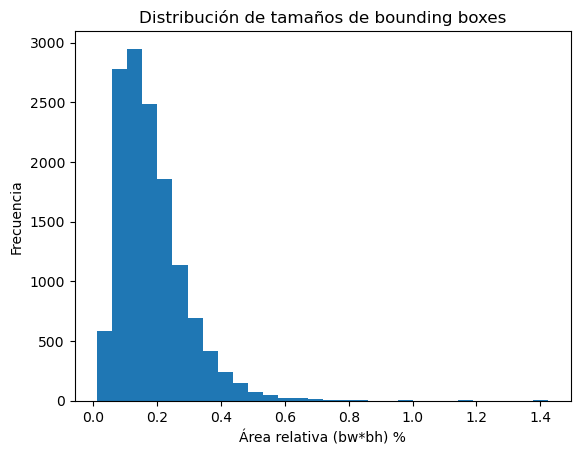

In [ ]:
# --- Path to your train folder ---
BASE = Path("D:/PhawAI-TB-Detection/data/train")
IM = BASE/"images"   # Not "images/train"
LB = BASE/"labels"   # Not "labels/train"

# --- Load class names from YAML if you want ---
import yaml
with open("D:/PhawAI-TB-Detection/data/data.yaml") as f:
    data_yaml = yaml.safe_load(f)
classes = data_yaml['names']  # list of class names

# --- Conteo por clase ---
counts = {i:0 for i in range(len(classes))}
areas  = []

for lbl in LB.glob("*.txt"):
    for line in lbl.read_text().splitlines():
        cid, xc, yc, bw, bh = map(float, line.split())
        counts[int(cid)] += 1
        areas.append(bw*bh*100)  # area in percentage of image

# --- Print counts ---
for cid, count in counts.items():
    print(f"{classes[cid]}: {count}")

# --- Histograma de tamaño relativo de cajas ---
plt.hist(areas, bins=30)
plt.xlabel("Área relativa (bw*bh) %")
plt.ylabel("Frecuencia")
plt.title("Distribución de tamaños de bounding boxes")
plt.show()


Se observa que el área relativa de los defectos es mínima, alrededor del 0.1%, lo que confirma que este tipo de fallas es difícil de observar a simple vista.

### Visualizaciones previas

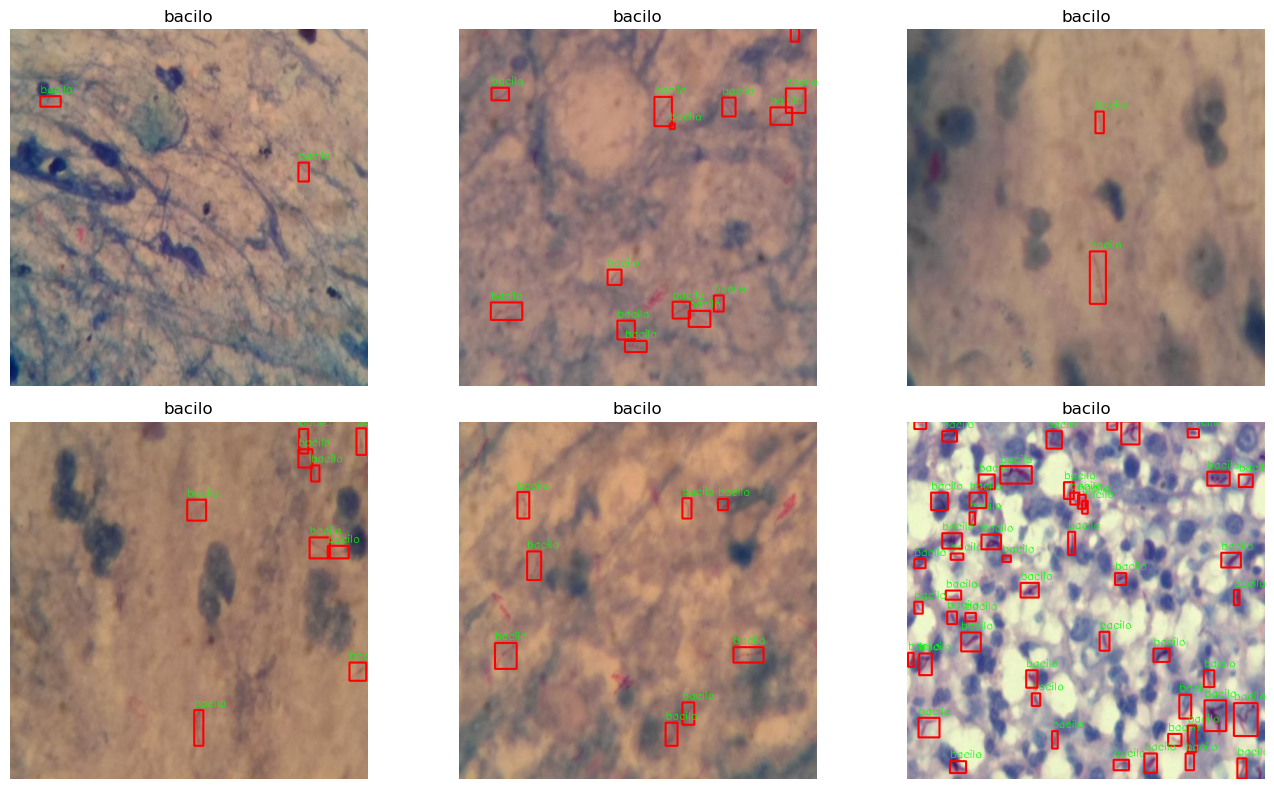

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path("D:/PhawAI-TB-Detection/data/train")
IM = BASE/"images"
LB = BASE/"labels"

class_name = "bacilo"  

def draw_boxes(img_p, lbl_p):
    img = cv2.imread(str(img_p))
    h, w = img.shape[:2]
    for ln in open(lbl_p):
        cid, xc, yc, bw, bh = map(float, ln.split())
        x1, y1 = int((xc-bw/2)*w), int((yc-bh/2)*h)
        x2, y2 = int((xc+bw/2)*w), int((yc+bh/2)*h)
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),2)
        cv2.putText(img, class_name, (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Pick 6 random label files
lbl_files = list(LB.glob("*.txt"))
lbl_files = np.random.choice(lbl_files, size=6, replace=False)

fig, ax = plt.subplots(2,3, figsize=(14,8))
for i, lbl in enumerate(lbl_files):
    img_p = IM/(lbl.stem + ".jpg")
    a = ax.ravel()[i]
    a.imshow(draw_boxes(img_p, lbl))
    a.set_title(class_name)
    a.axis("off")

plt.tight_layout()
plt.show()


# Entrenamiento

En los siguientes bloques se realiza el entrenamiento del modelo.

In [10]:
from ultralytics import YOLO
import time, glob, os, shutil

In [12]:
DATA = "data/data.yaml"  # your YAML for train/valid
CHECKPOINT = "model/yolov8n.pt"  # starting from YOLOv8n pre-trained

def train_and_validate(run_name, epochs=20, imgsz=512, batch=8):
    # Load model
    model = YOLO(CHECKPOINT)
    
    # Train
    model.train(
        data=DATA,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=5,   # early stopping patience
        seed=18,
        project="runs/detect",
        name=run_name,
        cache='ram'  # or 'disk' if dataset too big
    )
    
    # Validate on the validation set defined in data.yaml
    metrics = model.val(data=DATA, imgsz=imgsz, verbose=True)
    
    # Extract mAP metrics
    res = getattr(metrics, "results_dict", {})
    print({
        "model": run_name,
        "mAP@0.5": round(res.get("metrics/mAP50(B)", 0.0), 4),
        "mAP@0.5:0.95": round(res.get("metrics/mAP50-95(B)", 0.0), 4)
    })
    
    return model, metrics

### YOLOv8n

In [14]:
model, metrics = train_and_validate("yolov8n_tb_clean")

New https://pypi.org/project/ultralytics/8.3.225 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=model/yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_tb_clean, nbs=64, nms=False, opset=None, optimize=False, optimizer=a

In [16]:
# Current best weights from previous 20 epochs
CHECKPOINT = "runs/detect/yolov8n_tb_clean/weights/best.pt"

# Train 20 more epochs
model, metrics = train_and_validate(run_name="yolov8n_tb_clean2_continue", epochs=30)


New https://pypi.org/project/ultralytics/8.3.225 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/yolov8n_tb_clean/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_tb_clean2_continue, nbs=64, nms=False, o

# Evaluación

In [17]:
DATA = "data/data.yaml"
MODEL_PATH = "runs/detect/yolov8n_tb_clean/weights/best.pt"

model = YOLO(MODEL_PATH)

# Validate on your validation set
metrics = model.val(data=DATA, imgsz=512, verbose=True)
rd = getattr(metrics, "results_dict", {})

print({
    "mAP@0.5": round(rd.get("metrics/mAP50(B)", 0.0), 4),
    "mAP@0.5:0.95": round(rd.get("metrics/mAP50-95(B)", 0.0), 4),
    "Precision": round(rd.get("metrics/precision(B)", 0.0), 4),
    "Recall": round(rd.get("metrics/recall(B)", 0.0), 4)
})

Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 11.416.1 MB/s, size: 18.1 KB)
val: Scanning D:\PhawAI-TB-Detection\data\valid\labels.cache... 367 images, 11 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 367/367 183207.5it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 1.3it/s 18.4s
                   all        367       4657      0.759       0.78      0.803      0.323
Speed: 1.8ms preprocess, 39.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val
{'mAP@0.5': 0.8027, 'mAP@0.5:0.95': 0.3228, 'Precision': 0.7586, 'Recall': 0.7795}


# Inferencia de ejemplo


image 1/1 d:\PhawAI-TB-Detection\data\test\images\00385_jpg.rf.ffab8c2bab5c8aa8db9befb4d119ccd1.jpg: 512x512 49 bacilos, 165.2ms
Speed: 6.7ms preprocess, 165.2ms inference, 9.7ms postprocess per image at shape (1, 3, 512, 512)


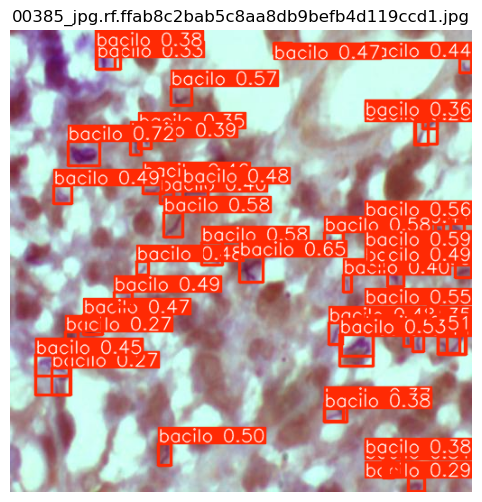


image 1/1 d:\PhawAI-TB-Detection\data\test\images\tuberculosis-phone-0430_jpg.rf.a252433f8b27318444fd02c53fe14363.jpg: 512x512 7 bacilos, 35.9ms
Speed: 1.1ms preprocess, 35.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)


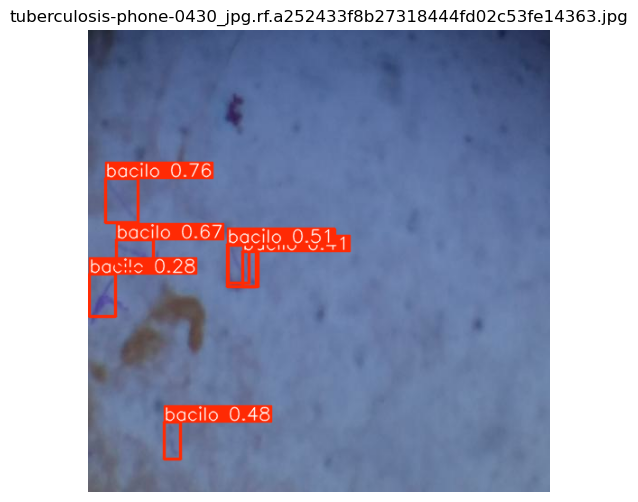


image 1/1 d:\PhawAI-TB-Detection\data\test\images\tuberculosis-phone-1255_jpg.rf.2e57814d3b0090bd791f833dd699d911.jpg: 512x512 18 bacilos, 46.6ms
Speed: 6.9ms preprocess, 46.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)


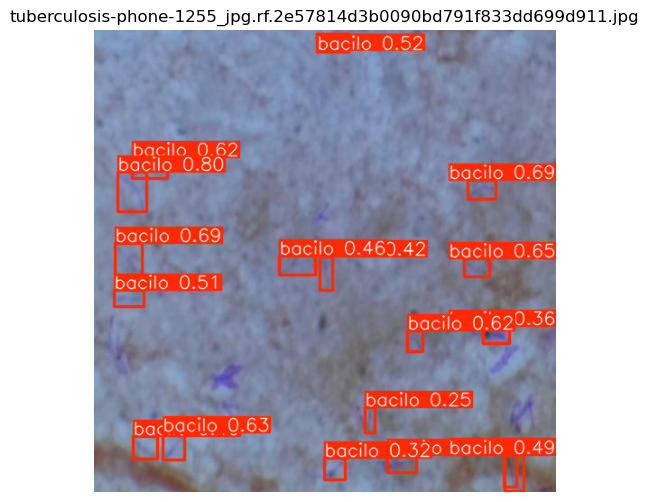

In [ ]:
%matplotlib inline
import glob, os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Paths
DATA_YOLO = "data"
TEST_IM_DIR = os.path.join(DATA_YOLO, "test/images")
MODEL_PATH = "runs/detect/yolov8n_tb_clean/weights/best.pt"

# Pick 3 random test images
all_test_imgs = glob.glob(os.path.join(TEST_IM_DIR, "*.jpg"))
assert len(all_test_imgs) >= 3, "Need at least 3 test images."
test_imgs = np.random.choice(all_test_imgs, size=3, replace=False)

# Load the model
model = YOLO(MODEL_PATH)

# Run inference and plot results
for img_path in test_imgs:
    results = model.predict(img_path)
    # Get image with boxes drawn
    img_with_boxes = results[0].plot()  # returns RGB image with boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(img_with_boxes)
    plt.title(os.path.basename(img_path))
    plt.axis("off")
    plt.show()



image 1/1 d:\PhawAI-TB-Detection\data\test\images\tuberculosis-phone-0908_jpg.rf.d6b6d1fd1f87f0f8194fea4ba2cc6ebc.jpg: 512x512 2 bacilos, 39.6ms
Speed: 0.8ms preprocess, 39.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)


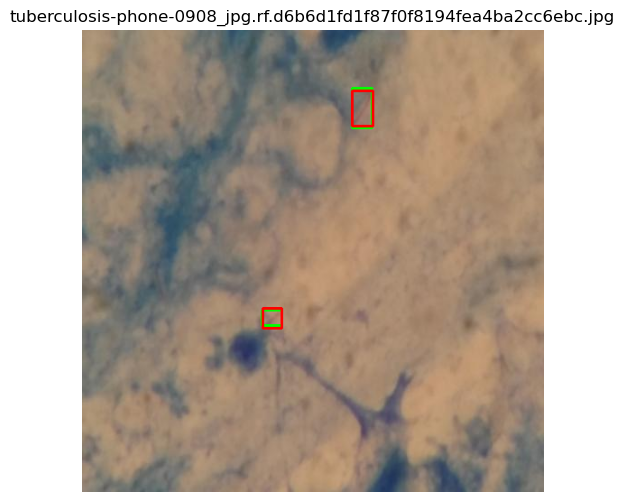


image 1/1 d:\PhawAI-TB-Detection\data\test\images\tuberculosis-phone-0809_jpg.rf.a467cb7214a8ea7d83b5ba6dd9938d89.jpg: 512x512 25 bacilos, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)


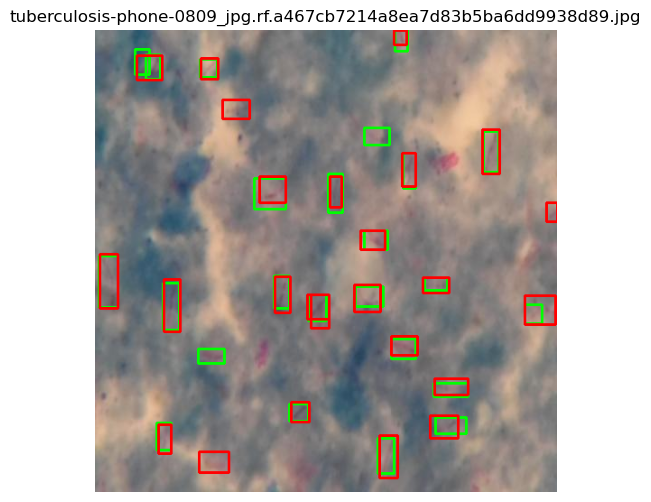


image 1/1 d:\PhawAI-TB-Detection\data\test\images\00367-5-_jpg.rf.5307d1de0312167f193240af287399ca.jpg: 512x512 53 bacilos, 48.1ms
Speed: 1.0ms preprocess, 48.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)


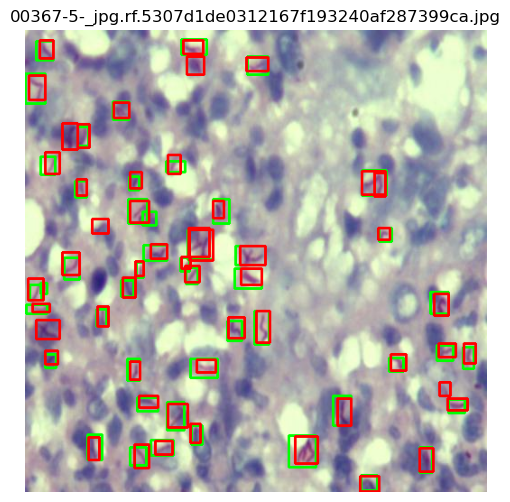

In [21]:
import matplotlib.pyplot as plt
import cv2
import os
import glob
from ultralytics import YOLO

DATA_YOLO = "data"
TEST_IM_DIR = os.path.join(DATA_YOLO, "test/images")
LABEL_DIR = os.path.join(DATA_YOLO, "test/labels")
MODEL_PATH = "runs/detect/yolov8n_tb_clean/weights/best.pt"

# Pick 3 random test images
all_test_imgs = glob.glob(os.path.join(TEST_IM_DIR, "*.jpg"))
test_imgs = np.random.choice(all_test_imgs, size=3, replace=False)

# Load model
model = YOLO(MODEL_PATH)

def draw_boxes(img, boxes, color=(0,255,0), thickness=2):
    """Draw boxes from list of [x1, y1, x2, y2] on an image."""
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, thickness)
    return img

for img_path in test_imgs:
    # Load image
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # --- Ground truth ---
    label_path = os.path.join(LABEL_DIR, os.path.basename(img_path).replace(".jpg",".txt"))
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                gt_boxes.append([x1, y1, x2, y2])
    
    # --- Predictions ---
    results = model.predict(img_path)
    pred_boxes = []
    for box in results[0].boxes.xyxy:  # xyxy format
        pred_boxes.append(box.cpu().numpy())
    
    # Draw both on the image
    img_gt = draw_boxes(img.copy(), gt_boxes, color=(0,255,0), thickness=2)       # green = ground truth
    img_all = draw_boxes(img_gt, pred_boxes, color=(0,0,255), thickness=2)        # red = predictions

    # Show
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(img_path))
    plt.axis("off")
    plt.show()


# Export to TFLite

In [6]:
from ultralytics import YOLO

model = YOLO('runs/detect/yolov8n_tb_clean/weights/best.pt')

model.export(format='tflite')

Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\yolov8n_tb_clean\weights\best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 5, 5376) (5.9 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'ai-edge-litert>=1.2.0,<1.4.0'] not found, attempting AutoUpdate...
WARNING Retry 1/2 failed: Command 'pip install --no-cache-dir "sng4onnx>=1.0.1" "ai-edge-litert>=1.2.0,<1.4.0" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING Retry 2/2 failed: Command 'pip install --no-cache-dir "sng4onnx>=1.0.1" "ai-edge-litert>=1.2.0,<1.4.0" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING requirements:  Command 'pip install --no-cache-dir "sng4onnx>=1.0.1" "ai-edge-litert>=1.2.0,<1.4.0" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.


ModuleNotFoundError: No module named 'ai_edge_litert'